# Geospatial Analysis

Geospatial analysis plays a critical role in understanding the spatial distribution of crimes across districts. By leveraging a JSON file containing district-level geospatial data, we relate geographical areas to their corresponding crime statistics for visualization and deeper insights.

## Approach

1. **Mapping Districts to Crime Data:**
   The geospatial JSON file is used to define the boundaries and locations of districts. This data is merged with crime statistics to establish a spatial relationship between districts and their respective crime levels.

2. **Visualization with Heatmaps:**
   Heatmaps are generated to highlight regions with varying crime intensities. Districts with higher crime rates are represented with more intense colors, making it easier to identify crime hotspots visually.

3. **Identifying High-Crime Areas:**
   Using the heatmap, we pinpoint districts with persistently high crime rates. These areas are marked for further investigation and targeted interventions by law enforcement and policymakers.

4. **Correlation Analysis:**
   Geospatial correlations are analyzed to explore relationships between crime levels and socio-economic factors such as population density, urbanization, and literacy rates. This helps uncover patterns and potential drivers of crime in specific regions.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


geojson_path = 'india (1).geojson'  # Adjust path if needed
india_geo = gpd.read_file(geojson_path)

# Inspect the loaded GeoDataFrame structure
print("GeoDataFrame Columns:", india_geo.columns)

# Extract the latitude and longitude from the geometry
india_geo['latitude'] = india_geo.geometry.centroid.y
india_geo['longitude'] = india_geo.geometry.centroid.x

# Extract relevant columns for merging (adjust based on your crime data)
geo_coordinates = india_geo[['district', 'latitude', 'longitude']]

#  2: Load the crime dataset
crime_data_path = 'crime.csv'  # Adjust path if needed
crime_data = pd.read_csv(crime_data_path)

# Ensure district names match by cleaning up whitespace and cases
crime_data['DISTRICT'] = crime_data['DISTRICT'].str.strip().str.lower()
geo_coordinates['district'] = geo_coordinates['district'].str.strip().str.lower()

#  3: Merge crime data with geo coordinates on district names
merged_data = crime_data.merge(geo_coordinates, left_on='DISTRICT', right_on='district', how='left')

# Check for any rows with missing latitude or longitude
missing_coords = merged_data[merged_data[['latitude', 'longitude']].isnull().any(axis=1)]
print("Rows with missing coordinates after merge:")
print(missing_coords[['DISTRICT', 'latitude', 'longitude']].head())

# Drop rows with missing coordinates (if any)
merged_data = merged_data.dropna(subset=['latitude', 'longitude'])



#  Convert to GeoDataFrame for visualization
gdf = gpd.GeoDataFrame(
    merged_data, 
    geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude),
    crs="EPSG:4326"
)




GeoDataFrame Columns: Index(['id', 'district', 'dt_code', 'st_nm', 'st_code', 'year', 'geometry'], dtype='object')
Rows with missing coordinates after merge:
         DISTRICT  latitude  longitude
3        cuddapah       NaN        NaN
4       cyberabad       NaN        NaN
6   guntakal rly.       NaN        NaN
8    guntur urban       NaN        NaN
9  hyderabad city       NaN        NaN


C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\3876589737.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  india_geo['latitude'] = india_geo.geometry.centroid.y
C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\3876589737.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  india_geo['longitude'] = india_geo.geometry.centroid.x
C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\3876589737.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_coordinates['

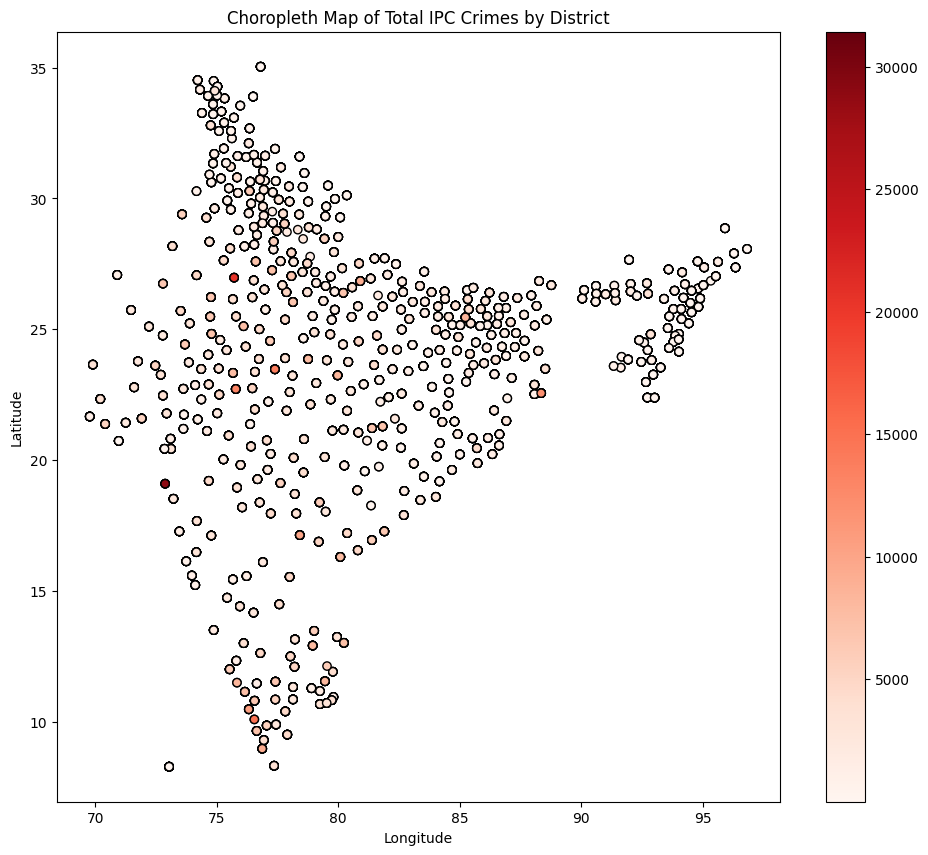

In [3]:
# Plot Total IPC Crimes as a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(column='TOTAL IPC CRIMES', 
         cmap='Reds', 
         legend=True, 
         ax=ax, 
         edgecolor='black')
plt.title('Choropleth Map of Total IPC Crimes by District')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


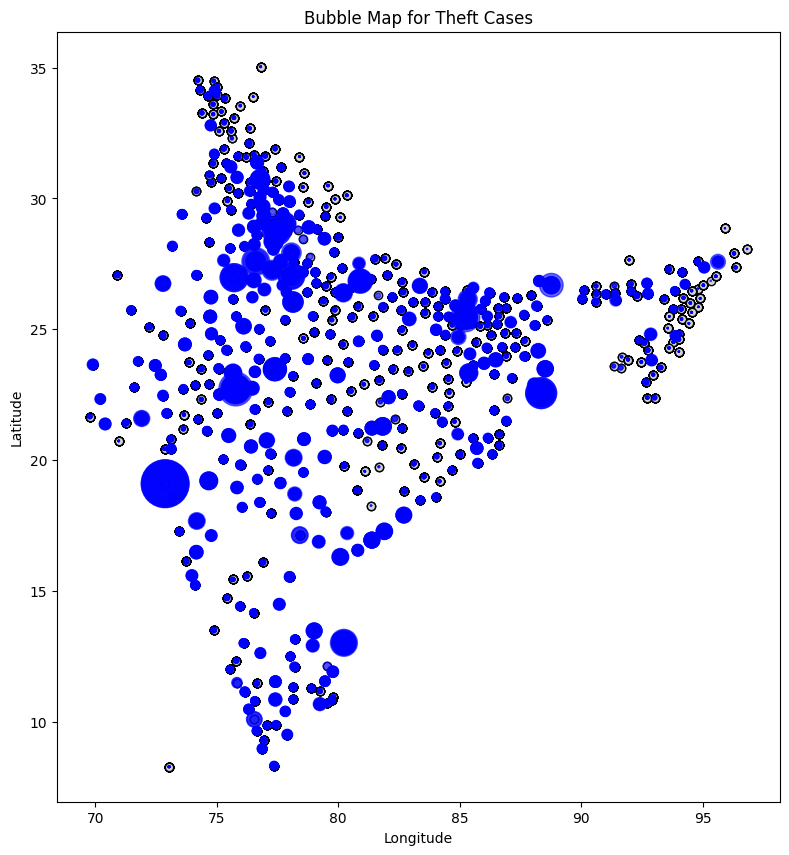

In [4]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, markersize=gdf['THEFT'] / 10, alpha=0.6, color='blue', legend=True)
plt.title('Bubble Map for Theft Cases')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


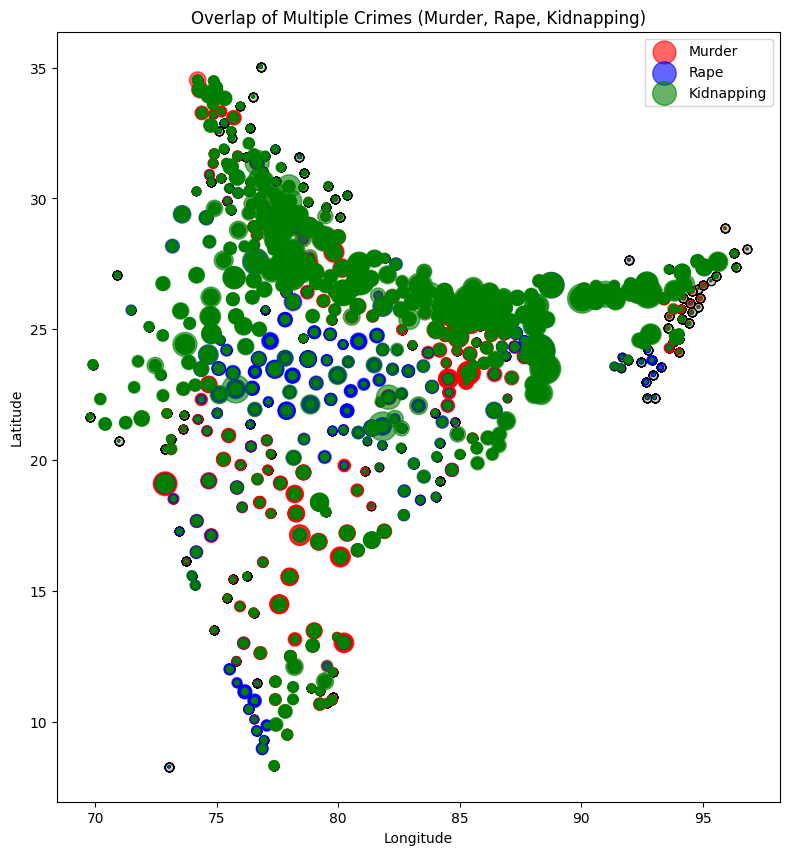

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Overlay multiple crimes with alpha blending
gdf.plot(ax=ax, markersize=gdf['MURDER'], color='red', alpha=0.6, label='Murder')
gdf.plot(ax=ax, markersize=gdf['RAPE'], color='blue', alpha=0.6, label='Rape')
gdf.plot(ax=ax, markersize=gdf['KIDNAPPING & ABDUCTION'], color='green', alpha=0.6, label='Kidnapping')

plt.legend()
plt.title('Overlap of Multiple Crimes (Murder, Rape, Kidnapping)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Animated Visualization of Crime Trends in India

This interactive visualization dynamically showcases the increase in crime rates across India over the years. It provides two synchronized views: a geospatial map of crime distribution and a bar chart highlighting the top 10 districts with the highest crime rates for each year.


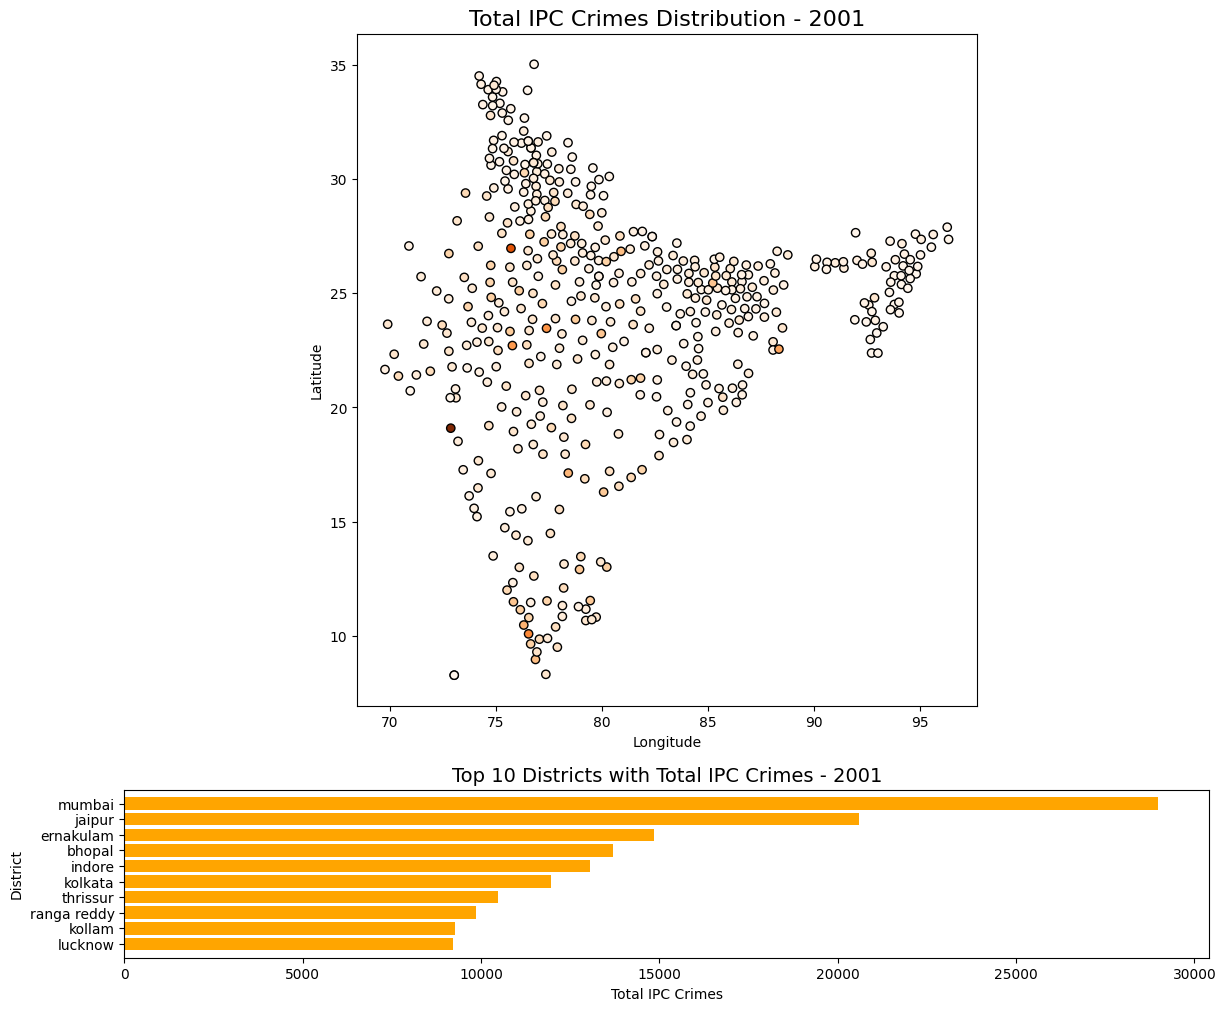

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from IPython.display import HTML

# Prepare Data (assuming `gdf` contains merged crime and geospatial data)
years = sorted(merged_data['YEAR'].unique())  # Sorted list of years

# Initialize the figure with fixed layout
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(2, 1, height_ratios=[4, 1], figure=fig)  # More space for the map
ax_map = fig.add_subplot(gs[0])
ax_bar = fig.add_subplot(gs[1])

# Update function for animation
def update(year):
    # Clear axes
    ax_map.clear()
    ax_bar.clear()
    
    # Filter data for the selected year
    yearly_data = gdf[gdf['YEAR'] == year]
    
    # Map plot without the legend (scale bar)
    yearly_data.plot(column='TOTAL IPC CRIMES', 
                     cmap='Oranges', 
                     ax=ax_map, 
                     edgecolor='black', 
                     legend=False)  # Turn off legend here
    ax_map.set_title(f'Total IPC Crimes Distribution - {year}', fontsize=16)
    ax_map.set_xlabel('Longitude')
    ax_map.set_ylabel('Latitude')
    
    # Bar chart
    top_districts = yearly_data[['DISTRICT', 'TOTAL IPC CRIMES']].sort_values(by='TOTAL IPC CRIMES', ascending=False).head(10)
    ax_bar.barh(top_districts['DISTRICT'], top_districts['TOTAL IPC CRIMES'], color='orange')
    ax_bar.set_title(f'Top 10 Districts with Total IPC Crimes - {year}', fontsize=14)
    ax_bar.set_xlabel('Total IPC Crimes')
    ax_bar.set_ylabel('District')
    ax_bar.invert_yaxis()  # Highest crime at the top

# Create animation
ani = FuncAnimation(fig, update, frames=years, repeat=False)

# Display animation in notebook
HTML(ani.to_jshtml())

# Save the animation as MP4 (optional)
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=2, metadata=dict(artist='Crime Data Animation'))
# ani.save('crime_map_bar_animation.mp4', writer=writer)


GeoDataFrame Columns: Index(['id', 'district', 'dt_code', 'st_nm', 'st_code', 'year', 'geometry'], dtype='object')
Rows with missing coordinates after merge:
         DISTRICT  latitude  longitude
3        cuddapah       NaN        NaN
4       cyberabad       NaN        NaN
6   guntakal rly.       NaN        NaN
8    guntur urban       NaN        NaN
9  hyderabad city       NaN        NaN
Number of districts with murder cases above 48.77164973391388: 2405


C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\1185144519.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  india_geo['latitude'] = india_geo.geometry.centroid.y
C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\1185144519.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  india_geo['longitude'] = india_geo.geometry.centroid.x
C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\1185144519.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_coordinates['

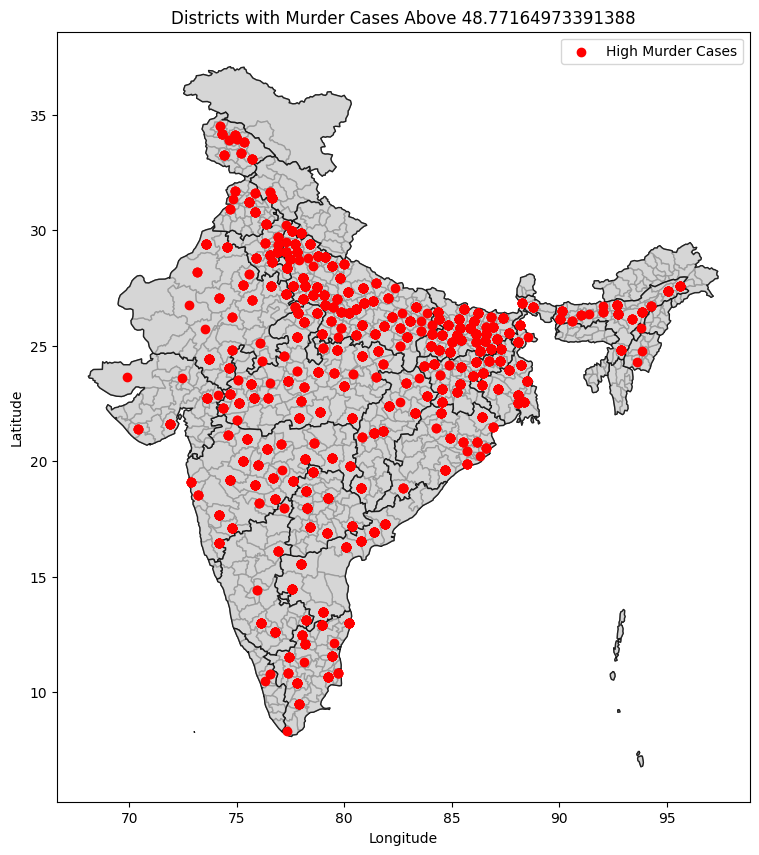

C:\Users\Prakash\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Prakash\AppData\Local\Temp\ipykernel_16276\1185144519.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_murder_data['cluster'] = kmeans.fit_predict(coordinates)


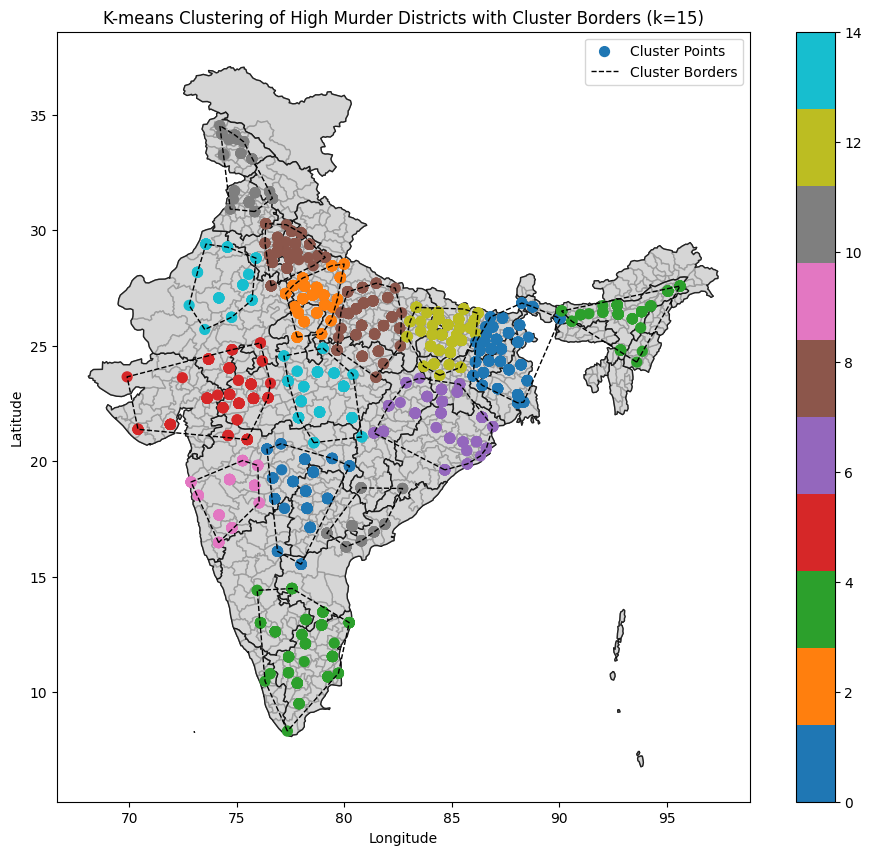

Clustered data saved as 'high_murder_districts_clusters_with_borders.csv'.
Filtered data saved as 'high_murder_districts.csv'.


In [8]:
# code for threshold trial  plus k means plus convex hull

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

#  1: Load the GeoJSON file as a GeoDataFrame
geojson_path = 'india (1).geojson'  # Adjust path if needed
india_geo = gpd.read_file(geojson_path)

# Inspect the loaded GeoDataFrame structure
print("GeoDataFrame Columns:", india_geo.columns)

# Extract the latitude and longitude from the geometry
india_geo['latitude'] = india_geo.geometry.centroid.y
india_geo['longitude'] = india_geo.geometry.centroid.x

# Extract relevant columns for merging (adjust based on your crime data)
geo_coordinates = india_geo[['district', 'latitude', 'longitude']]

#  2: Load the crime dataset
crime_data_path = 'crime.csv'  # Adjust path if needed
crime_data = pd.read_csv(crime_data_path)

# Ensure district names match by cleaning up whitespace and cases
crime_data['DISTRICT'] = crime_data['DISTRICT'].str.strip().str.lower()
geo_coordinates['district'] = geo_coordinates['district'].str.strip().str.lower()

#  3: Merge crime data with geo coordinates on district names
merged_data = crime_data.merge(geo_coordinates, left_on='DISTRICT', right_on='district', how='left')

# Check for any rows with missing latitude or longitude
missing_coords = merged_data[merged_data[['latitude', 'longitude']].isnull().any(axis=1)]
print("Rows with missing coordinates after merge:")
print(missing_coords[['DISTRICT', 'latitude', 'longitude']].head())

# Drop rows with missing coordinates (if any)
merged_data = merged_data.dropna(subset=['latitude', 'longitude'])

#  4: Filter districts with murder cases above a threshold
#murder_threshold = 100 # Set your threshold here

murder_mean = merged_data['MURDER'].mean()
murder_threshold=murder_mean
high_murder_data = merged_data[merged_data['MURDER'] > murder_threshold]

print(f"Number of districts with murder cases above {murder_threshold}: {len(high_murder_data)}")

#  5: Convert to GeoDataFrame for visualization
gdf_high_murder = gpd.GeoDataFrame(
    high_murder_data, 
    geometry=gpd.points_from_xy(high_murder_data.longitude, high_murder_data.latitude),
    crs="EPSG:4326"
)

#  6: Plot the districts with high murder cases
fig, ax = plt.subplots(figsize=(12, 10))
india_geo.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
gdf_high_murder.plot(ax=ax, color='red', marker='o', label='High Murder Cases')
plt.title(f'Districts with Murder Cases Above {murder_threshold}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

from sklearn.cluster import KMeans
from shapely.geometry import MultiPoint

#  7: Prepare data for K-means clustering
coordinates = high_murder_data[['latitude', 'longitude']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=15, random_state=42)
high_murder_data['cluster'] = kmeans.fit_predict(coordinates)

#  8: Convert the clustered data to a GeoDataFrame
gdf_clusters = gpd.GeoDataFrame(
    high_murder_data, 
    geometry=gpd.points_from_xy(high_murder_data.longitude, high_murder_data.latitude),
    crs="EPSG:4326"
)

#  9: Create polygons (convex hulls) for each cluster
cluster_polygons = []
for cluster_id in sorted(high_murder_data['cluster'].unique()):
    cluster_points = gdf_clusters[gdf_clusters['cluster'] == cluster_id].geometry
    if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
        cluster_polygons.append({
            'cluster': cluster_id,
            'geometry': MultiPoint([point.coords[0] for point in cluster_points]).convex_hull
        })

# Convert cluster polygons to a GeoDataFrame
gdf_cluster_polygons = gpd.GeoDataFrame(cluster_polygons, crs="EPSG:4326")

#  10: Visualize the clustered districts with borders
fig, ax = plt.subplots(figsize=(12, 10))
india_geo.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
gdf_clusters.plot(ax=ax, column='cluster', cmap='tab10', legend=True, markersize=50, label='Cluster Points')
gdf_cluster_polygons.boundary.plot(ax=ax, color='black', linestyle='--', linewidth=1, label='Cluster Borders')
plt.title('K-means Clustering of High Murder Districts with Cluster Borders (k=15)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Save the clustered data
clustered_output_path = 'high_murder_districts_clusters_with_borders.csv'
high_murder_data.to_csv(clustered_output_path, index=False)
print(f"Clustered data saved as '{clustered_output_path}'.")



# Save the filtered data for high murder districts
output_path = 'high_murder_districts.csv'
high_murder_data.to_csv(output_path, index=False)
print(f"Filtered data saved as '{output_path}'.")
